In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sid22072000","key":"0700ea0e4f3d542db18c3d8df6ac800f"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d obulisainaren/multi-cancer

100% 8.61G/8.62G [01:34<00:00, 129MB/s] 
100% 8.62G/8.62G [01:34<00:00, 97.8MB/s]


In [3]:
!unzip '/content/multi-cancer.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0002.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0003.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0004.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0005.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0006.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0007.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0008.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0009.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0010.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0011.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0012.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0013.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0014.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0015.jpg  
  inflating

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

In [6]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [7]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

In [8]:
class ImageDataProcessor:
    def __init__(self, path):
        self.base_path = path
        self.train_datagen = ImageDataGenerator(validation_split=0.3)
        self.no_of_classes = 0
        self.class_names = []

    def initiate_generator(self):
        self._generate_dataset()
        self._generate_data_generators()
        self._plot_sample_images()
        self._print_image_shape()
        return self.class_names, self.no_of_classes, self.train_generator, self.validation_generator

    def _generate_dataset(self):
        print("\nTotal : ", end=" ")
        self.train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=self.base_path)
        self.class_names = self.train_dataset.class_names
        self.no_of_classes = len(self.class_names)

    def _generate_data_generators(self):
        self.train_generator = self._create_generator(subset='training')
        self.validation_generator = self._create_generator(subset='validation', shuffle=False)
        print("\nNo of Classes : ", self.no_of_classes)
        print("Classes : ", self.class_names)

    def _create_generator(self, subset, shuffle=True):
        print(f"\nFor {subset.capitalize()} : ", end=" ")
        return self.train_datagen.flow_from_directory(
            self.base_path,
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical',
            subset=subset,
            shuffle=shuffle
        )

    def _plot_sample_images(self):
        plt.figure(figsize=(10, 10))
        for images, labels in self.train_dataset.take(1):
            for i in range(self.no_of_classes):
                ax = plt.subplot(4, 4, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(self.class_names[labels[i]])
                plt.axis("off")

    def _print_image_shape(self):
        for image_batch, _ in self.train_dataset.take(1):
            print("Image Shape : ", image_batch.shape)
            break

In [9]:
class DataNormalizer:
    def __init__(self, train_generator, val_generator):
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.normalized_ds = None
        self.AUTOTUNE = tf.data.AUTOTUNE

    def initiate_normalize(self):
        self._prepare_datasets()
        self._normalize_datasets()
        self._display_sample()

    def _prepare_datasets(self):
        self.train_ds = self.train_generator.cache().shuffle(1000).prefetch(buffer_size=self.AUTOTUNE)
        self.val_ds = self.val_generator.cache().prefetch(buffer_size=self.AUTOTUNE)

    def _normalize_datasets(self):
        normalization_layer = layers.Rescaling(1./255)
        self.normalized_ds = self.train_ds.map(lambda x, y: (normalization_layer(x), y))

    def _display_sample(self):
        image_batch, labels_batch = next(iter(self.normalized_ds))
        first_image = image_batch[0]
        print(f"Min pixel value: {np.min(first_image)}, Max pixel value: {np.max(first_image)}")


In [10]:
class ImageClassifier:
    def __init__(self, no_of_classes, image_size, class_name, train_generator, validation_generator):
        self.no_of_classes = no_of_classes
        self.image_size = image_size
        self.class_name = class_name
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.model = None
        self.annealer = None
        self.checkpoint = None

    def initiate_model(self):
        model_input = tf.keras.applications.VGG16(
            input_shape=self.image_size + [3],
            include_top=False,
            weights="imagenet"
        )

        for layer in model_input.layers:
            layer.trainable = False

        x = Flatten()(model_input.output)
        prediction = Dense(self.no_of_classes, activation='softmax')(x)

        self.model = Model(inputs=model_input.input, outputs=prediction)
        return self.model

    def model_summary(self):
        if self.model is not None:
            self.model.summary()
        else:
            print("Model has not been initialized yet.")


    def initiate_params(self, lr):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        self.annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
        self.checkpoint = ModelCheckpoint(self.class_name + 'VGG16.h5', verbose=1, save_best_only=True)

        return self.model, self.annealer, self.checkpoint

    def model_fit(self, epochs=20, batch_size=256):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        history = self.model.fit(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[self.annealer, self.checkpoint],
            steps_per_epoch=len(self.train_generator),
            validation_steps=len(self.validation_generator)
        )
        return history

    def eval_model(self):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        evl = self.model.evaluate(self.validation_generator)
        acc = evl[1] * 100
        msg = f'Accuracy on the Test Set = {acc:5.2f} %'
        print(msg)

    def save_model(self):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        file_path = self.class_name + " - VGG16.h5"
        self.model.save(file_path)
        print(f"Model saved to {file_path}!")



In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

class PlotMetrics:

    def plot_output(self, history, epochs):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(epochs)

        sns.set(style='whitegrid')
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        sns.lineplot(epochs_range, acc, label='Training Accuracy')
        sns.lineplot(epochs_range, val_acc, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        sns.lineplot(epochs_range, loss, label='Training Loss')
        sns.lineplot(epochs_range, val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')

        plt.tight_layout()
        plt.show()
        plt.savefig(self.class_name + '_performance_graph.png')

    def plot_confusion_matrix(self, cm, target_names, title='Confusion matrix', normalize=True):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', cbar=False,
                    xticklabels=target_names, yticklabels=target_names)
        plt.title(title)
        plt.ylabel('True label')
        plt.xlabel(f'Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}')
        plt.tight_layout()
        plt.show()
        plt.savefig(title + '.png')

    def call_plot(self):
        y_true = self.validation_generator.classes
        y_pred = self.model.predict(self.validation_generator)
        y_pred = np.argmax(y_pred, axis=1)
        conf_mat = confusion_matrix(y_true, y_pred)

        self.plot_confusion_matrix(cm=conf_mat,
                                   normalize=False,
                                   target_names=self.class_names,
                                   title=self.class_name + " Confusion Matrix")


In [12]:
data_dir = '/content/Multi Cancer'
cancer_classes = os.listdir(data_dir)
print(cancer_classes)

['ALL', 'Breast Cancer', 'Oral Cancer', 'Brain Cancer', 'Cervical Cancer', 'Lung and Colon Cancer', 'Kidney Cancer', 'Lymphoma']


#Cervical Caner


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Validation :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
58889256/58889256 [==============================] - 0s 0us/step


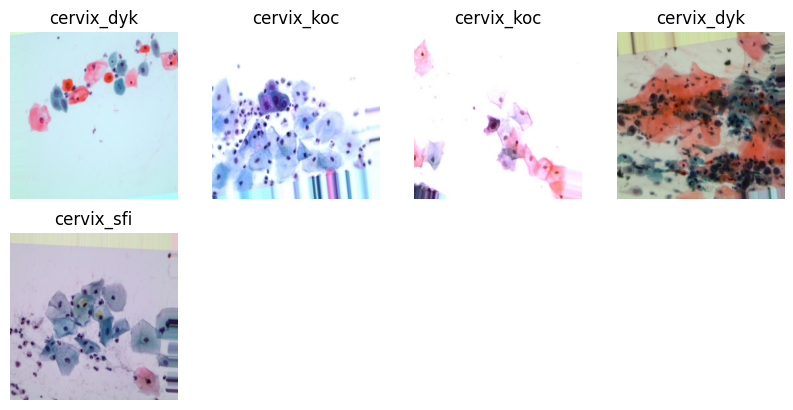

In [13]:
target_class = 'Cervical Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
cervical_model = classifierObj.initiate_model()

In [14]:
cervical_model, cervical_annealer, cervical_model_checkpoints = classifierObj.initiate_params(lr=0.001)
cervical_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
547/547 [==============================] - ETA: 0s - loss: 1.5656 - accuracy: 0.9203
Epoch 1: val_loss improved from inf to 0.56545, saving model to Cervical CancerVGG16.h5
547/547 [==============================] - 127s 216ms/step - loss: 1.5656 - accuracy: 0.9203 - val_loss: 0.5655 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


547/547 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 0.9833
Epoch 2: val_loss did not improve from 0.56545
547/547 [==============================] - 100s 183ms/step - loss: 0.3173 - accuracy: 0.9833 - val_loss: 0.9874 - val_accuracy: 0.9628 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.9871
Epoch 3: val_loss did not improve from 0.56545
547/547 [==============================] - 112s 204ms/step - loss: 0.3168 - accuracy: 0.9871 - val_loss: 0.7062 - val_accuracy: 0.9772 - lr: 0.0010
Epoch 4/10
547/547 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9899
Epoch 4: val_loss improved from 0.56545 to 0.44037, saving model to Cervical CancerVGG16.h5
547/547 [==============================] - 106s 194ms/step - loss: 0.2261 - accuracy: 0.9899 - val_loss: 0.4404 - val_accuracy: 0.9872 - lr: 0.0010
Epoch 5/10
547/547 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.99

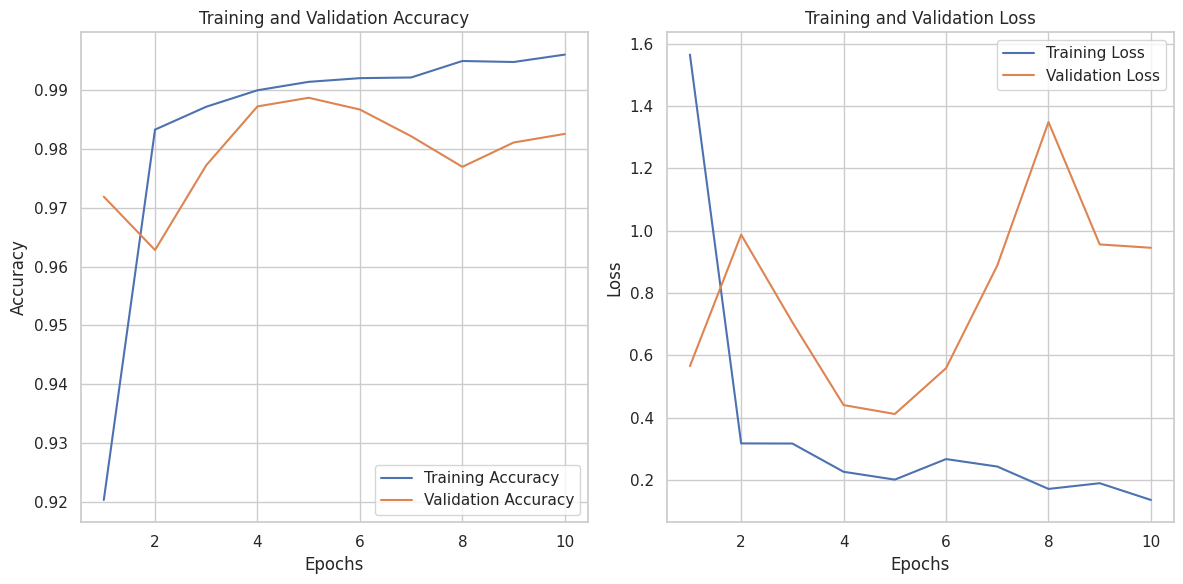

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

class PlotMetrics:
    def plot_output(self, history, epochs):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(1, epochs + 1)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.lineplot(x=epochs_range, y=acc, label='Training Accuracy')
        sns.lineplot(x=epochs_range, y=val_acc, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend(loc='lower right')

        plt.subplot(1, 2, 2)
        sns.lineplot(x=epochs_range, y=loss, label='Training Loss')
        sns.lineplot(x=epochs_range, y=val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

# Assuming `cervical_model_history` is a history object returned by the `.fit()` method of a Keras model,
# and you've trained for 10 epochs:
plot_metrics_obj = PlotMetrics()
plot_metrics_obj.plot_output(cervical_model_history, 10)


#Brain Cancer


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Validation :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)


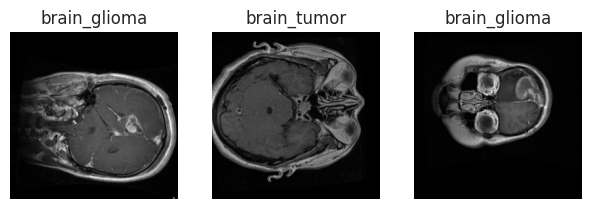

In [18]:
target_class = 'Brain Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
brain_model = classifierObj.initiate_model()

In [19]:
brain_model, brain_annealer, brain_model_checkpoints = classifierObj.initiate_params(lr=0.001)
brain_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 2.4920 - accuracy: 0.8870
Epoch 1: val_loss improved from inf to 1.65129, saving model to Brain CancerVGG16.h5
329/329 [==============================] - 65s 196ms/step - loss: 2.4920 - accuracy: 0.8870 - val_loss: 1.6513 - val_accuracy: 0.9307 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 0.8892 - accuracy: 0.9554
Epoch 2: val_loss did not improve from 1.65129
329/329 [==============================] - 60s 183ms/step - loss: 0.8892 - accuracy: 0.9554 - val_loss: 2.0408 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 0.4571 - accuracy: 0.9768
Epoch 3: val_loss improved from 1.65129 to 1.26875, saving model to Brain CancerVGG16.h5
329/329 [==============================] - 61s 187ms/step - loss: 0.4571 - accuracy: 0.9768 - val_loss: 1.2688 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 4/10
329/329 [==============================] - ETA: 0s - loss: 0.2813 - accuracy: 0.9838
Epoch 4: val_loss improved from 1.26875 to 0.97781, saving model to Brain CancerVGG16.h5
329/329 [==============================] - 65s 197ms/step - loss: 0.2813 - accuracy: 0.9838 - val_loss: 0.9778 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 5/10
329/329 [==========================

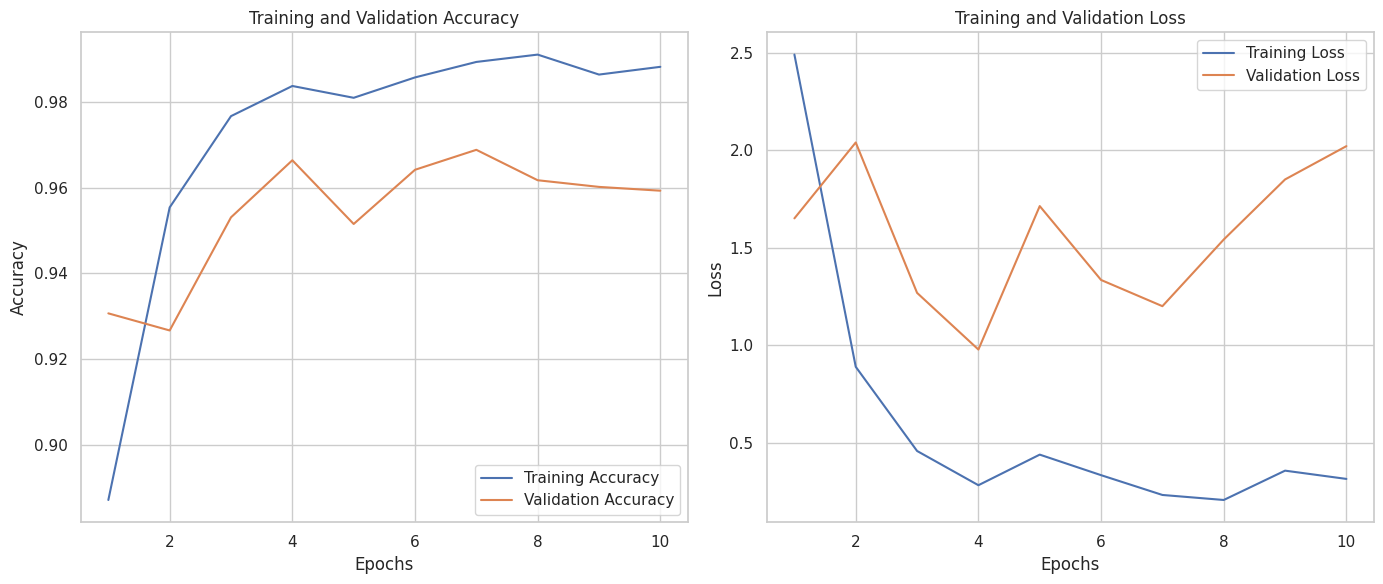

In [20]:
def plot_training_history(history, epochs):
    # Extracting accuracy and loss values for plotting
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Setting the range of epochs
    epochs_range = range(1, epochs + 1)

    # Plotting Training and Validation Accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs_range, y=acc, label='Training Accuracy')
    sns.lineplot(x=epochs_range, y=val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs_range, y=loss, label='Training Loss')
    sns.lineplot(x=epochs_range, y=val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Now, call this function with your history object and the number of epochs
plot_training_history(brain_model_history, 10)


#Kidney Cancer


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Validation :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)


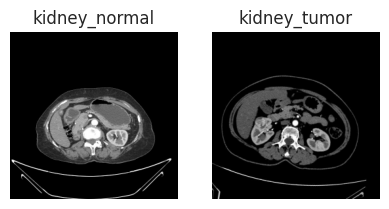

In [21]:
target_class = 'Kidney Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
kidney_model = classifierObj.initiate_model()

In [22]:
kidney_model, kidney_annealer, kidney_model_checkpoints = classifierObj.initiate_params(lr=0.001)
kidney_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.9450 - accuracy: 0.9713
Epoch 1: val_loss improved from inf to 6.54884, saving model to Kidney CancerVGG16.h5
219/219 [==============================] - 47s 209ms/step - loss: 0.9450 - accuracy: 0.9713 - val_loss: 6.5488 - val_accuracy: 0.8160 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9990
Epoch 2: val_loss did not improve from 6.54884
219/219 [==============================] - 40s 182ms/step - loss: 0.0070 - accuracy: 0.9990 - val_loss: 7.0671 - val_accuracy: 0.8193 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 1.0932e-04 - accuracy: 1.0000
Epoch 3: val_loss improved from 6.54884 to 4.78471, saving model to Kidney CancerVGG16.h5
219/219 [==============================] - 39s 180ms/step - loss: 1.0932e-04 - accuracy: 1.0000 - val_loss: 4.7847 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 4/10
219/219 [==============================] - ETA: 0s - loss: 1.1574e-07 - accuracy: 1.0000
Epoch 4: val_loss improved from 4.78471 to 4.44046, saving model to Kidney CancerVGG16.h5
219/219 [==============================] - 39s 179ms/step - loss: 1.1574e-07 - accuracy: 1.0000 - val_loss: 4.4405 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 5/10
219/219 [========

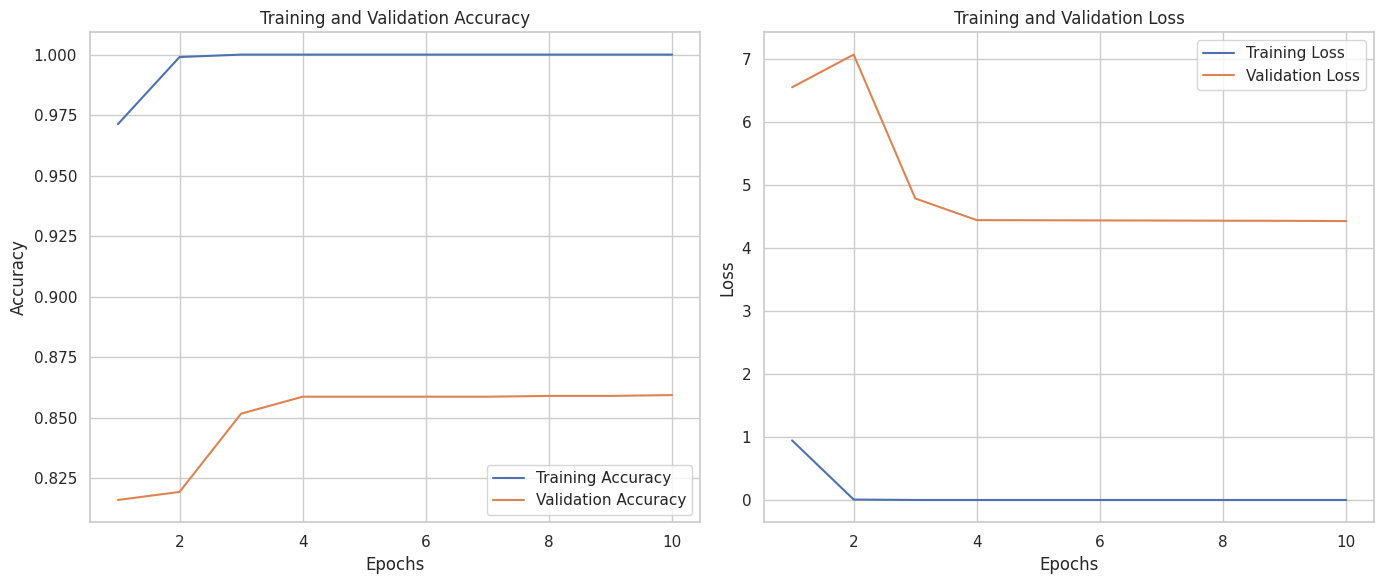

In [23]:
def plot_training_history(history, epochs):
    # Extract accuracy and loss values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Prepare the range of epochs
    epochs_range = range(1, epochs + 1)

    # Create figure for plotting
    plt.figure(figsize=(14, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs_range, y=acc, label='Training Accuracy')
    sns.lineplot(x=epochs_range, y=val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs_range, y=loss, label='Training Loss')
    sns.lineplot(x=epochs_range, y=val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function with your model's history and the number of epochs
plot_training_history(kidney_model_history, 10)


#Breast Cancer


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Validation :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)


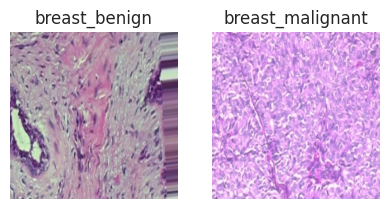

In [24]:
target_class = 'Breast Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
breast_model = classifierObj.initiate_model()

In [25]:
breast_model, breast_annealer, breast_model_checkpoints = classifierObj.initiate_params(lr=0.001)
breast_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.8802 - accuracy: 0.9640
Epoch 1: val_loss improved from inf to 0.35613, saving model to Breast CancerVGG16.h5
219/219 [==============================] - 87s 392ms/step - loss: 0.8802 - accuracy: 0.9640 - val_loss: 0.3561 - val_accuracy: 0.9840 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9911
Epoch 2: val_loss did not improve from 0.35613
219/219 [==============================] - 88s 401ms/step - loss: 0.1967 - accuracy: 0.9911 - val_loss: 0.5949 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9954
Epoch 3: val_loss did not improve from 0.35613
219/219 [==============================] - 68s 310ms/step - loss: 0.0865 - accuracy: 0.9954 - val_loss: 0.4747 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 4/10
219/219 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9969
Epoch 4: val_loss did not improve from 0.35613
219/219 [==============================] - 67s 308ms/step - loss: 0.0421 - accuracy: 0.9969 - val_loss: 0.5930 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 5/10
219/219 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9977
Epoch 5: val_loss did not improve 

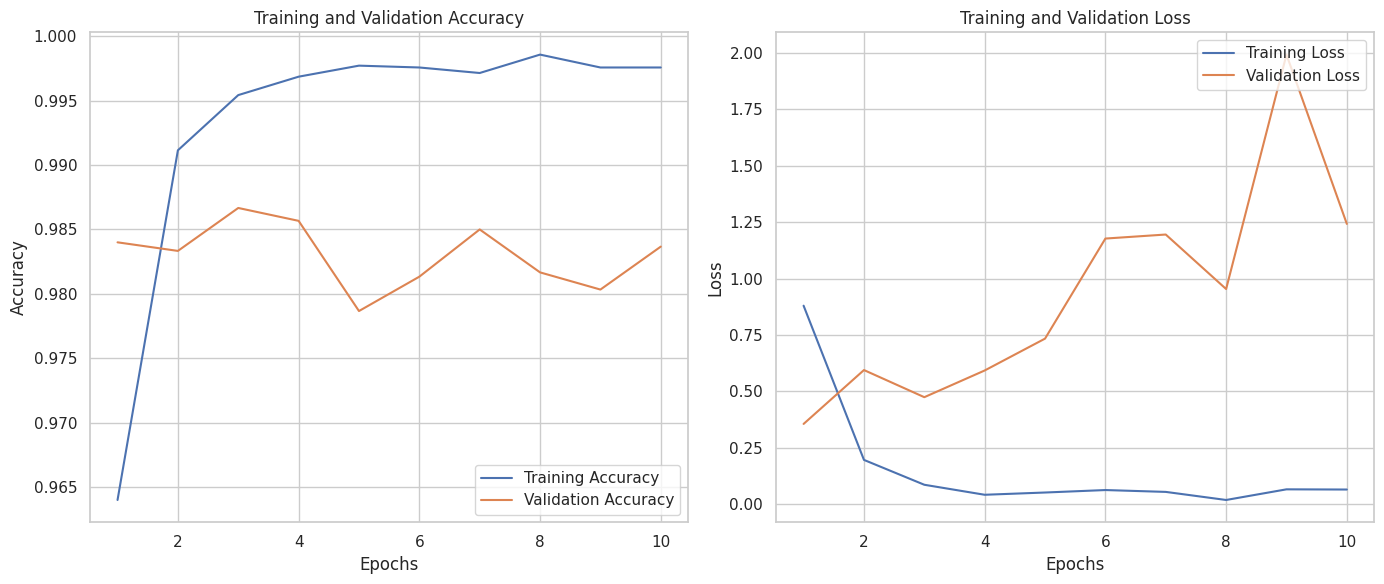

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history, epochs):
    # Extracting accuracy and loss values for plotting
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Setting the range of epochs
    epochs_range = range(1, epochs + 1)

    # Creating a figure for two subplots (2 rows, 1 column)
    plt.figure(figsize=(14, 6))

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
    sns.lineplot(x=epochs_range, y=acc, label='Training Accuracy')
    sns.lineplot(x=epochs_range, y=val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
    sns.lineplot(x=epochs_range, y=loss, label='Training Loss')
    sns.lineplot(x=epochs_range, y=val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    # Displaying the plot
    plt.tight_layout()
    plt.show()

# Now, call this function with your history object and the number of epochs you trained for
plot_training_history(breast_model_history, 10)


#Lung and Colon Cancer


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Validation :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)


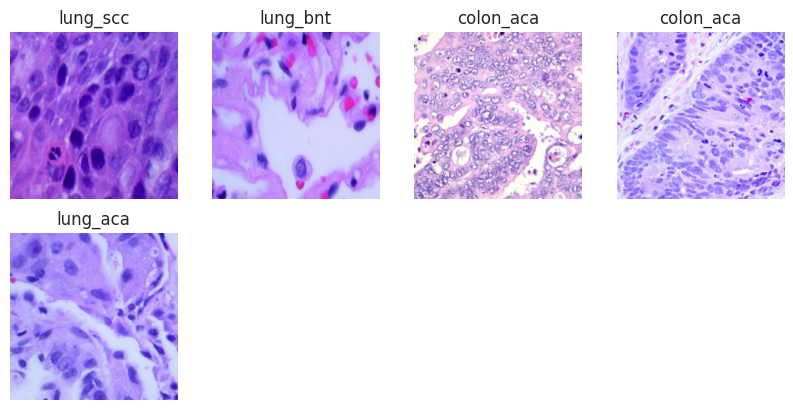

In [27]:
target_class = 'Lung and Colon Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
lung_model = classifierObj.initiate_model()

In [28]:
lung_model, lung_annealer, lung_model_checkpoints = classifierObj.initiate_params(lr=0.001)
lung_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
547/547 [==============================] - ETA: 0s - loss: 1.4139 - accuracy: 0.9390
Epoch 1: val_loss improved from inf to 0.62365, saving model to Lung and Colon CancerVGG16.h5
547/547 [==============================] - 110s 199ms/step - loss: 1.4139 - accuracy: 0.9390 - val_loss: 0.6237 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


547/547 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.9811
Epoch 2: val_loss improved from 0.62365 to 0.61657, saving model to Lung and Colon CancerVGG16.h5
547/547 [==============================] - 101s 185ms/step - loss: 0.4423 - accuracy: 0.9811 - val_loss: 0.6166 - val_accuracy: 0.9784 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - ETA: 0s - loss: 0.3029 - accuracy: 0.9873
Epoch 3: val_loss did not improve from 0.61657
547/547 [==============================] - 101s 185ms/step - loss: 0.3029 - accuracy: 0.9873 - val_loss: 0.7182 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 4/10
547/547 [==============================] - ETA: 0s - loss: 0.2415 - accuracy: 0.9907
Epoch 4: val_loss did not improve from 0.61657
547/547 [==============================] - 101s 185ms/step - loss: 0.2415 - accuracy: 0.9907 - val_loss: 1.4053 - val_accuracy: 0.9679 - lr: 0.0010
Epoch 5/10
547/547 [==============================] - ETA: 0s - loss: 0.2936 - accuracy

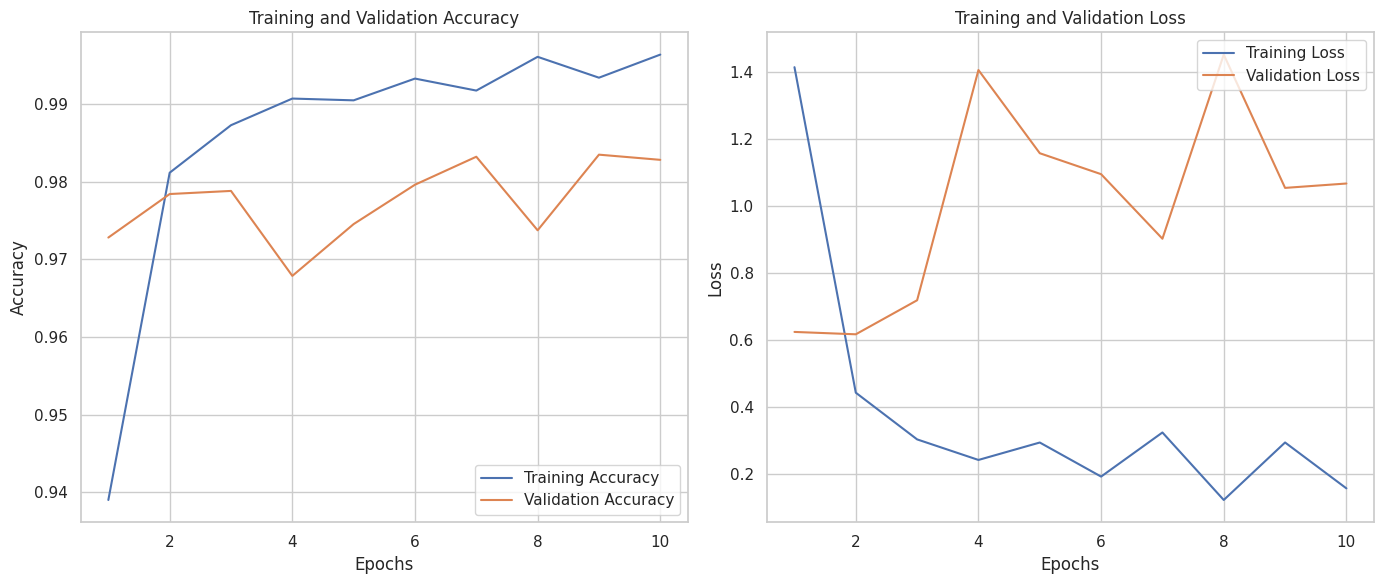

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history, epochs):
    # Extracting accuracy and loss values for plotting
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Setting the range of epochs
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 6))

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs_range, y=acc, label='Training Accuracy')
    sns.lineplot(x=epochs_range, y=val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs_range, y=loss, label='Training Loss')
    sns.lineplot(x=epochs_range, y=val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function with the history object and the number of epochs you've trained for
plot_training_history(lung_model_history, 10)


#Lymphoma


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Validation :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)


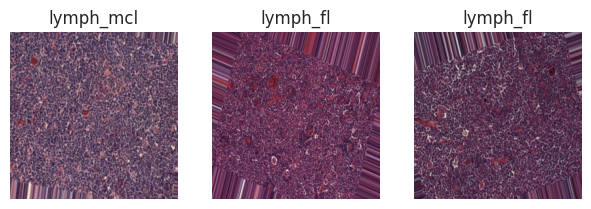

In [30]:
target_class = 'Lymphoma'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
lymph_model = classifierObj.initiate_model()

In [31]:
lymph_model, lymph_annealer, lymph_model_checkpoints = classifierObj.initiate_params(lr=0.001)
lymph_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 5.4957 - accuracy: 0.6529
Epoch 1: val_loss improved from inf to 3.03102, saving model to LymphomaVGG16.h5
329/329 [==============================] - 77s 230ms/step - loss: 5.4957 - accuracy: 0.6529 - val_loss: 3.0310 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


329/329 [==============================] - ETA: 0s - loss: 1.8979 - accuracy: 0.8422
Epoch 2: val_loss improved from 3.03102 to 2.32925, saving model to LymphomaVGG16.h5
329/329 [==============================] - 65s 196ms/step - loss: 1.8979 - accuracy: 0.8422 - val_loss: 2.3293 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 1.2510 - accuracy: 0.8935
Epoch 3: val_loss did not improve from 2.32925
329/329 [==============================] - 65s 197ms/step - loss: 1.2510 - accuracy: 0.8935 - val_loss: 4.5935 - val_accuracy: 0.7493 - lr: 0.0010
Epoch 4/10
329/329 [==============================] - ETA: 0s - loss: 1.1457 - accuracy: 0.9051
Epoch 4: val_loss did not improve from 2.32925
329/329 [==============================] - 86s 262ms/step - loss: 1.1457 - accuracy: 0.9051 - val_loss: 3.5164 - val_accuracy: 0.8053 - lr: 0.0010
Epoch 5/10
329/329 [==============================] - ETA: 0s - loss: 0.9984 - accuracy: 0.9230
Epoch 5

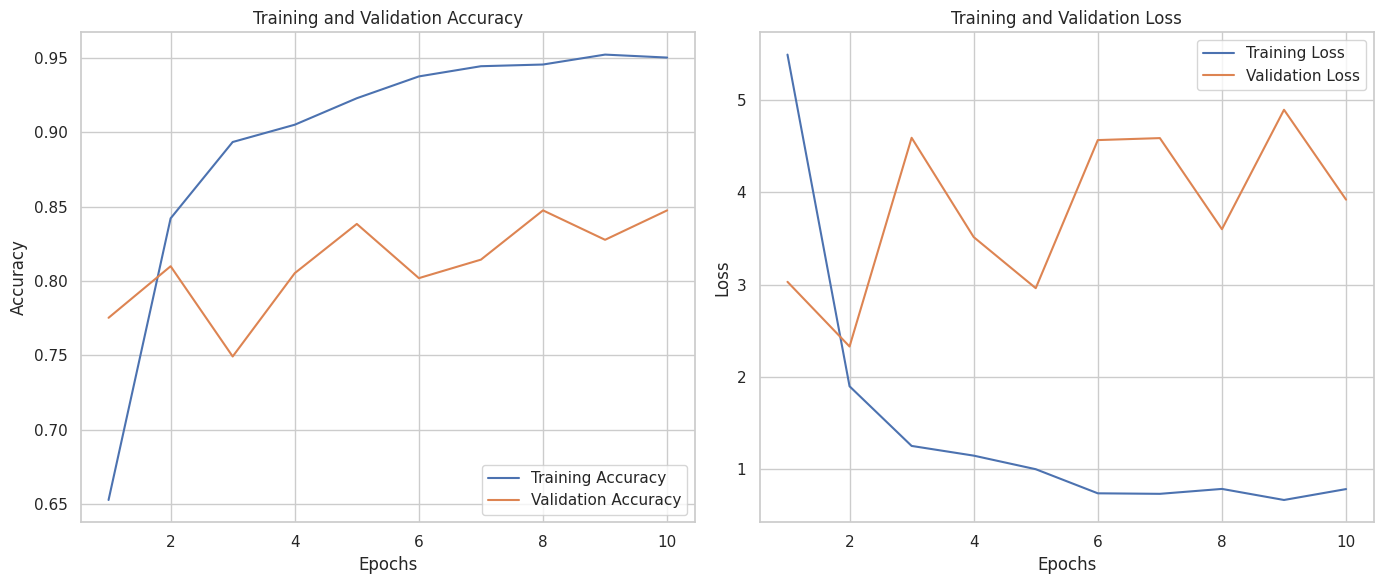

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history, epochs):
    # Extracting accuracy and loss values for plotting
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Setting the range of epochs
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 6))

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs_range, y=acc, label='Training Accuracy')
    sns.lineplot(x=epochs_range, y=val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs_range, y=loss, label='Training Loss')
    sns.lineplot(x=epochs_range, y=val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Now, call this function with your history object and the number of epochs you trained for
plot_training_history(lymph_model_history, 10)


#Oral Cancer


Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 7002 images belonging to 2 classes.

For Validation :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)


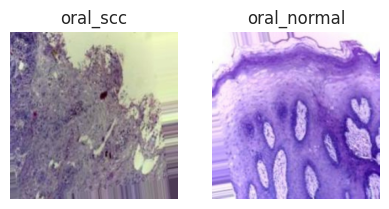

In [33]:
target_class = 'Oral Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
oral_model = classifierObj.initiate_model()

In [34]:
oral_model, oral_annealer, oral_model_checkpoints = classifierObj.initiate_params(lr=0.001)
oral_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 6.2810 - accuracy: 0.7365
Epoch 1: val_loss improved from inf to 5.12358, saving model to Oral CancerVGG16.h5
219/219 [==============================] - 52s 232ms/step - loss: 6.2810 - accuracy: 0.7365 - val_loss: 5.1236 - val_accuracy: 0.7927 - lr: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 2.4827 - accuracy: 0.8812
Epoch 2: val_loss did not improve from 5.12358
219/219 [==============================] - 40s 184ms/step - loss: 2.4827 - accuracy: 0.8812 - val_loss: 6.4968 - val_accuracy: 0.7853 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 1.3893 - accuracy: 0.9253
Epoch 3: val_loss did not improve from 5.12358
219/219 [==============================] - 40s 184ms/step - loss: 1.3893 - accuracy: 0.9253 - val_loss: 6.0295 - val_accuracy: 0.8287 - lr: 0.0010
Epoch 4/10
219/219 [==============================] - ETA: 0s - loss: 1.0079 - accuracy: 0.9422
Epoch 4: val_loss did not improve from 5.12358
219/219 [==============================] - 41s 185ms/step - loss: 1.0079 - accuracy: 0.9422 - val_loss: 5.8052 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 5/10
219/219 [==============================] - ETA: 0s - loss: 0.8956 - accuracy: 0.9529
Epoch 5: val_loss did not improve from 5.1235

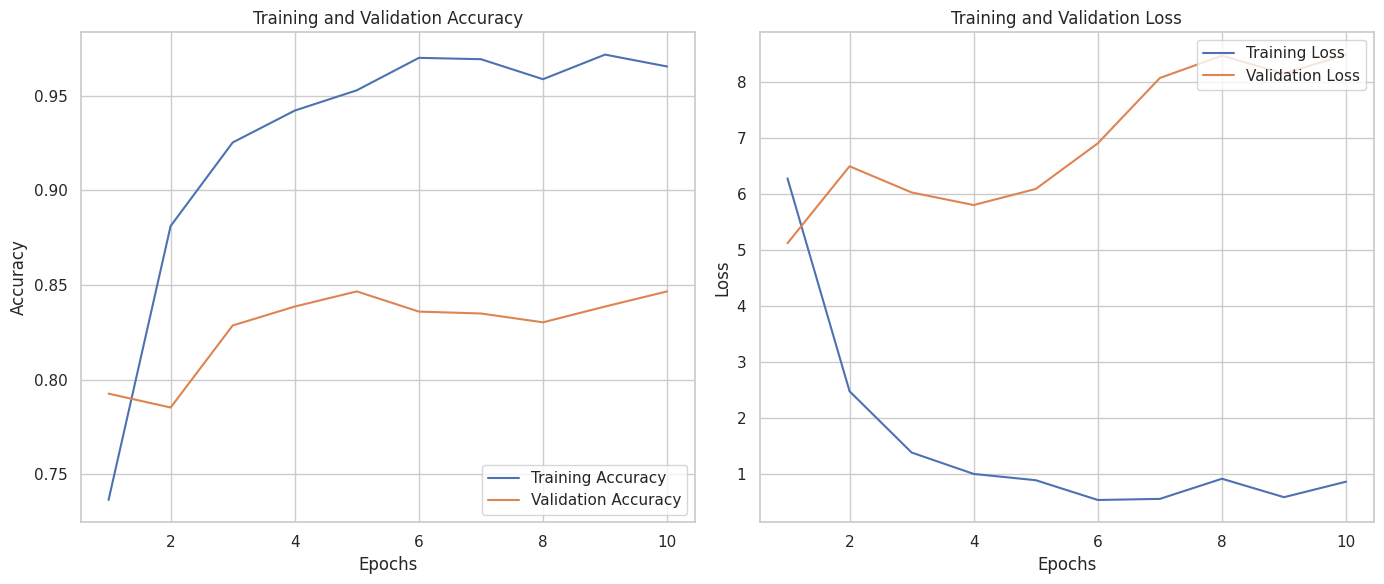

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history, epochs):
    # Extract accuracy and loss values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Define the range of epochs
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 6))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs_range, y=acc, label='Training Accuracy')
    sns.lineplot(x=epochs_range, y=val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs_range, y=loss, label='Training Loss')
    sns.lineplot(x=epochs_range, y=val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Use this function with your oral cancer model's training history and the number of epochs
plot_training_history(oral_model_history, 10)


In [36]:
import pandas as pd

# Assuming all history objects follow the naming convention "{cancer_type}_model_history"
# and have been defined in your workspace.

model_histories = {
    "Cervical": cervical_model_history,
    "Brain": brain_model_history,
    "Kidney": kidney_model_history,
    "Breast": breast_model_history,
    "Lung_and_Colon": lung_model_history,
    "Lymphoma": lymph_model_history,
    "Oral": oral_model_history
}

# Initialize an empty list to store epoch data
epoch_data = []

# Loop through each model's history to extract epoch data
for cancer_type, history in model_histories.items():
    for epoch in range(10):  # Assuming all models were trained for 10 epochs
        epoch_data.append({
            "Cancer Type": cancer_type,
            "Epoch": epoch + 1,
            "Training Accuracy": history.history['accuracy'][epoch],
            "Validation Accuracy": history.history['val_accuracy'][epoch],
            "Training Loss": history.history['loss'][epoch],
            "Validation Loss": history.history['val_loss'][epoch]
        })

# Create a DataFrame from the epoch data
epoch_df = pd.DataFrame(epoch_data)

# Display the DataFrame
print(epoch_df)


   Cancer Type  Epoch  Training Accuracy  Validation Accuracy  Training Loss  \
0     Cervical      1           0.920343             0.971867       1.565625   
1     Cervical      2           0.983257             0.962800       0.317254   
2     Cervical      3           0.987143             0.977200       0.316843   
3     Cervical      4           0.989943             0.987200       0.226127   
4     Cervical      5           0.991371             0.988667       0.200998   
..         ...    ...                ...                  ...            ...   
65        Oral      6           0.970009             0.836000       0.542949   
66        Oral      7           0.969294             0.835000       0.562283   
67        Oral      8           0.958726             0.830333       0.921981   
68        Oral      9           0.971722             0.838667       0.592766   
69        Oral     10           0.965438             0.846667       0.869741   

    Validation Loss  
0          0.5654

In [37]:
import pandas as pd

# Assuming all the history objects are named according to the cancer type followed by '_model_history'
# and all models have completed at least 10 epochs of training.

model_histories = {
    "Cervical": cervical_model_history,
    "Brain": brain_model_history,
    "Kidney": kidney_model_history,
    "Breast": breast_model_history,
    "Lung_and_Colon": lung_model_history,
    "Lymphoma": lymph_model_history,
    "Oral": oral_model_history
}

# Initialize an empty list to store the 10th epoch performance data for each model
epoch_10_data = []

# Extract the 10th epoch data from each model's history
for cancer_type, history in model_histories.items():
    epoch_10_data.append({
        "Cancer Type": cancer_type,
        "Training Accuracy": history.history['accuracy'][-1],  # Last epoch accuracy
        "Validation Accuracy": history.history['val_accuracy'][-1],  # Last epoch validation accuracy
        "Training Loss": history.history['loss'][-1],  # Last epoch loss
        "Validation Loss": history.history['val_loss'][-1]  # Last epoch validation loss
    })

# Convert the list of data into a Pandas DataFrame
epoch_10_df = pd.DataFrame(epoch_10_data)

# Sorting the DataFrame based on a specific column, e.g., 'Validation Accuracy', in descending order
epoch_10_df.sort_values(by='Validation Accuracy', ascending=False, inplace=True)

# Resetting the index of the DataFrame for better readability
epoch_10_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(epoch_10_df)


      Cancer Type  Training Accuracy  Validation Accuracy  Training Loss  \
0          Breast           0.997571             0.983667   6.533050e-02   
1  Lung_and_Colon           0.996343             0.982800   1.567040e-01   
2        Cervical           0.996000             0.982533   1.356174e-01   
3           Brain           0.988286             0.959333   3.136409e-01   
4          Kidney           1.000000             0.859333   1.677376e-08   
5        Lymphoma           0.950286             0.847556   7.828903e-01   
6            Oral           0.965438             0.846667   8.697410e-01   

   Validation Loss  
0         1.242793  
1         1.066630  
2         0.945392  
3         2.022044  
4         4.425353  
5         3.922298  
6         8.489123  


In [38]:
import pandas as pd
from tabulate import tabulate

# Assuming the DataFrame 'epoch_10_df' is already created as before

# Define a function for formatting the values to a specified number of decimal places
def format_dataframe(df, decimal_places=4):
    for column in df.columns:
        if df[column].dtype == 'float64':
            df[column] = df[column].map(lambda x: f'{x:.{decimal_places}f}')
    return df

# Format the DataFrame
epoch_10_df_formatted = format_dataframe(epoch_10_df.copy(), 4)

# Display the DataFrame using tabulate for a well-defined text table
print(tabulate(epoch_10_df_formatted, headers='keys', tablefmt='pretty', showindex=False))


+----------------+-------------------+---------------------+---------------+-----------------+
|  Cancer Type   | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss |
+----------------+-------------------+---------------------+---------------+-----------------+
|     Breast     |      0.9976       |       0.9837        |    0.0653     |     1.2428      |
| Lung_and_Colon |      0.9963       |       0.9828        |    0.1567     |     1.0666      |
|    Cervical    |      0.9960       |       0.9825        |    0.1356     |     0.9454      |
|     Brain      |      0.9883       |       0.9593        |    0.3136     |     2.0220      |
|     Kidney     |      1.0000       |       0.8593        |    0.0000     |     4.4254      |
|    Lymphoma    |      0.9503       |       0.8476        |    0.7829     |     3.9223      |
|      Oral      |      0.9654       |       0.8467        |    0.8697     |     8.4891      |
+----------------+-------------------+------------

In [41]:
import pandas as pd

# Assuming all history objects follow the naming convention "{cancer_type}_model_history"
# and have been defined in your workspace.

model_histories = {
    "Cervical": cervical_model_history,
    "Brain": brain_model_history,
    "Kidney": kidney_model_history,
    "Breast": breast_model_history,
    "Lung_and_Colon": lung_model_history,
    "Lymphoma": lymph_model_history,
    "Oral": oral_model_history
}

# Initialize an empty list to store data for the 10th epoch
epoch_10_data = []

# Extract data for the 10th epoch
for cancer_type, history in model_histories.items():
    epoch_10_data.append({
        "Cancer Type": cancer_type,
        "Training Accuracy": history.history['accuracy'][9],  # 10th epoch, zero-indexed
        "Validation Accuracy": history.history['val_accuracy'][9],
        "Training Loss": history.history['loss'][9],
        "Validation Loss": history.history['val_loss'][9]
    })

# Create a DataFrame from the 10th epoch data
epoch_10_df = pd.DataFrame(epoch_10_data)

# Reorder DataFrame columns if desired
epoch_10_df = epoch_10_df[['Cancer Type', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']]




In [44]:
print(epoch_10_df)


      Cancer Type  Training Accuracy  Validation Accuracy  Training Loss  \
0        Cervical           0.996000             0.982533   1.356174e-01   
1           Brain           0.988286             0.959333   3.136409e-01   
2          Kidney           1.000000             0.859333   1.677376e-08   
3          Breast           0.997571             0.983667   6.533050e-02   
4  Lung_and_Colon           0.996343             0.982800   1.567040e-01   
5        Lymphoma           0.950286             0.847556   7.828903e-01   
6            Oral           0.965438             0.846667   8.697410e-01   

   Validation Loss  
0         0.945392  
1         2.022044  
2         4.425353  
3         1.242793  
4         1.066630  
5         3.922298  
6         8.489123  


In [51]:
# prompt: print(epoch_10_df)
# make the printed table better

# Assuming the DataFrame 'epoch_10_df' is already created as before

# Define a function for formatting the values to a specified number of decimal places
def format_dataframe(df, decimal_places=4):
    for column in df.columns:
        if df[column].dtype == 'float64':
            df[column] = df[column].map(lambda x: f'{x:.{decimal_places}f}')
    return df

# Format the DataFrame
epoch_10_df_formatted = format_dataframe(epoch_10_df.copy(), 4)

# Display the DataFrame using tabulate for a well-defined text table
print(tabulate(epoch_10_df_formatted, headers='keys', tablefmt='pretty', showindex=False))


+----------------+-------------------+---------------------+---------------+-----------------+
|  Cancer Type   | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss |
+----------------+-------------------+---------------------+---------------+-----------------+
|    Cervical    |      0.9960       |       0.9825        |    0.1356     |     0.9454      |
|     Brain      |      0.9883       |       0.9593        |    0.3136     |     2.0220      |
|     Kidney     |      1.0000       |       0.8593        |    0.0000     |     4.4254      |
|     Breast     |      0.9976       |       0.9837        |    0.0653     |     1.2428      |
| Lung_and_Colon |      0.9963       |       0.9828        |    0.1567     |     1.0666      |
|    Lymphoma    |      0.9503       |       0.8476        |    0.7829     |     3.9223      |
|      Oral      |      0.9654       |       0.8467        |    0.8697     |     8.4891      |
+----------------+-------------------+------------

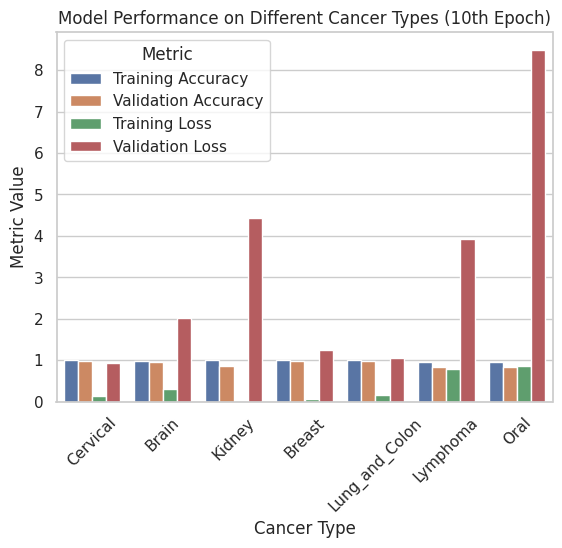

In [47]:
# prompt: suggest graph for above table

import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for the bar plot
df_bar = epoch_10_df.melt(id_vars='Cancer Type', var_name='Metric', value_name='Value')

# Create the bar plot with Seaborn
sns.barplot(x='Cancer Type', y='Value', hue='Metric', data=df_bar)
plt.title('Model Performance on Different Cancer Types (10th Epoch)')
plt.xlabel('Cancer Type')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.show()


In [45]:
# Export the DataFrame to an Excel file
excel_filename = "/content/cancer_model_epoch_10_summary.xlsx"
epoch_10_df.to_excel(excel_filename, index=False)

print(f"Summary table for the 10th epoch has been saved to {excel_filename}")

Summary table for the 10th epoch has been saved to /content/cancer_model_epoch_10_summary.xlsx


In [53]:
# prompt: save excel file in drive

from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Specify the path to your Excel file within your Google Drive
excel_file_path = '/content/drive/My Drive/cancer_model_epoch_10_summary.xlsx'

# Save the DataFrame to the specified path
epoch_10_df.to_excel(excel_file_path, index=False)

print(f"Summary table for the 10th epoch has been saved to {excel_file_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Summary table for the 10th epoch has been saved to /content/drive/My Drive/cancer_model_epoch_10_summary.xlsx
